# Atividade 2 - Etapa 2

In [5]:
import keras
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU

In [13]:
import numpy
import pandas as pd

df = pd.read_csv("Dataframe/articles.csv")
print('linhas, colunas):', df.shape)

df.head()

linhas, colunas): (167053, 6)


,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


**Ajustes para aprendizado - já realizados na Etapa1_v02**

In [14]:
df.drop_duplicates(subset=['text'], inplace=True)
df.drop(['subcategory', 'link', 'date'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,title,text,category
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,poder
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",ilustrada
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,poder
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,ilustrada
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",mercado


<Axes: xlabel='count', ylabel='category'>

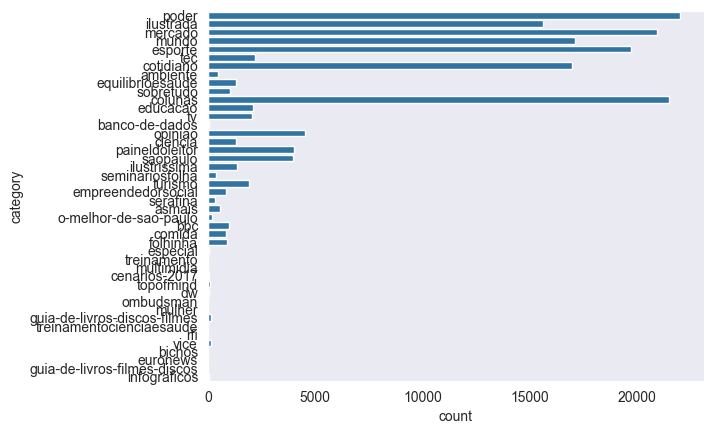

In [15]:
import seaborn as sns

sns.set_style("dark")
sns.countplot(df.category)

In [16]:
df['category'].value_counts()

category
poder                           22005
colunas                         21499
mercado                         20936
esporte                         19723
mundo                           17123
cotidiano                       16952
ilustrada                       15604
opiniao                          4523
paineldoleitor                   4008
saopaulo                         3953
tec                              2205
educacao                         2113
tv                               2065
turismo                          1902
ilustrissima                     1377
ciencia                          1331
equilibrioesaude                 1311
sobretudo                        1052
bbc                               979
folhinha                          875
empreendedorsocial                841
comida                            828
asmais                            547
ambiente                          490
seminariosfolha                   378
serafina                          331
o-m

In [17]:
df['category'] = df['category'].replace('guia-de-livros-discos-filmes', 'guia-de-livros-filmes-discos')
alvo, valores = pd.factorize(df['category'], sort=True)
df['target'] = alvo
list(enumerate(valores))

[(0, 'ambiente'),
 (1, 'asmais'),
 (2, 'banco-de-dados'),
 (3, 'bbc'),
 (4, 'bichos'),
 (5, 'cenarios-2017'),
 (6, 'ciencia'),
 (7, 'colunas'),
 (8, 'comida'),
 (9, 'cotidiano'),
 (10, 'dw'),
 (11, 'educacao'),
 (12, 'empreendedorsocial'),
 (13, 'equilibrioesaude'),
 (14, 'especial'),
 (15, 'esporte'),
 (16, 'euronews'),
 (17, 'folhinha'),
 (18, 'guia-de-livros-filmes-discos'),
 (19, 'ilustrada'),
 (20, 'ilustrissima'),
 (21, 'infograficos'),
 (22, 'mercado'),
 (23, 'mulher'),
 (24, 'multimidia'),
 (25, 'mundo'),
 (26, 'o-melhor-de-sao-paulo'),
 (27, 'ombudsman'),
 (28, 'opiniao'),
 (29, 'paineldoleitor'),
 (30, 'poder'),
 (31, 'rfi'),
 (32, 'saopaulo'),
 (33, 'seminariosfolha'),
 (34, 'serafina'),
 (35, 'sobretudo'),
 (36, 'tec'),
 (37, 'topofmind'),
 (38, 'treinamento'),
 (39, 'treinamentocienciaesaude'),
 (40, 'turismo'),
 (41, 'tv'),
 (42, 'vice')]

In [22]:
import nltk
import re, string, unicodedata
import matplotlib.pyplot as plt

from string import punctuation
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from wordcloud import WordCloud,STOPWORDS

#instalação do modelo 'stopwords'
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ferna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Remoção de Palavras Irrelevantes (Stopwords)**

Não acrescentam muito a sentença e podem ser facilmente ignoradas sem sacrificar o significado do texto.

In [19]:
stop = set(stopwords.words('portuguese'))
punctuation = list(string.punctuation)
stop.update(punctuation)

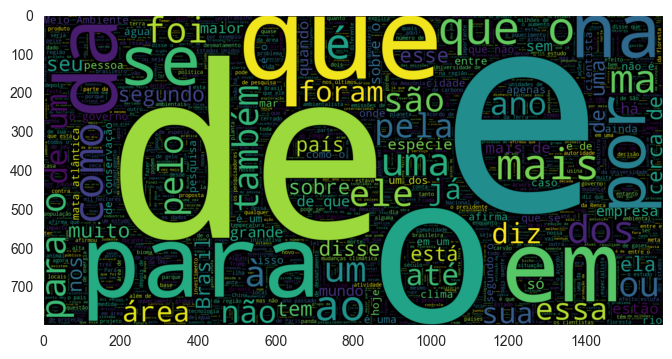

In [24]:
# criação de uma nuvem de palavras para textos da categoria 'ambiente'
plt.figure(figsize = (8, 8)) # Text that is Not Sarcastic
wc = WordCloud(max_words=2000 , width=1600 , height=800).generate(" ".join(df[df.category == 'ambiente'].text))
plt.imshow(wc , interpolation = 'bilinear')

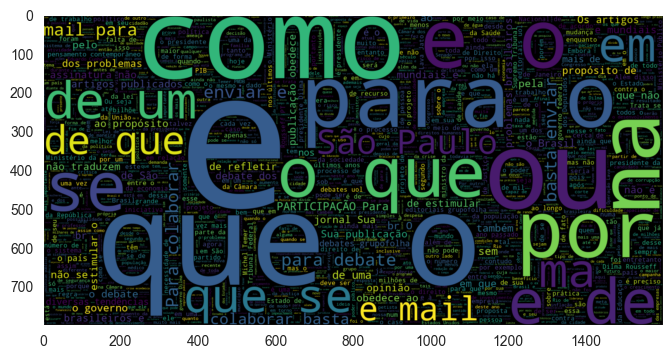

In [26]:
# criação de uma nuvem de palavras para textos da categoria 'poder'
plt.figure(figsize = (8, 8)) # Text that is Not Sarcastic
wc = WordCloud(max_words=2000 , width=1600 , height=800).generate(" ".join(df[df.category == 'opiniao'].text))
plt.imshow(wc , interpolation = 'bilinear')

**Número de caracteres nos textos**

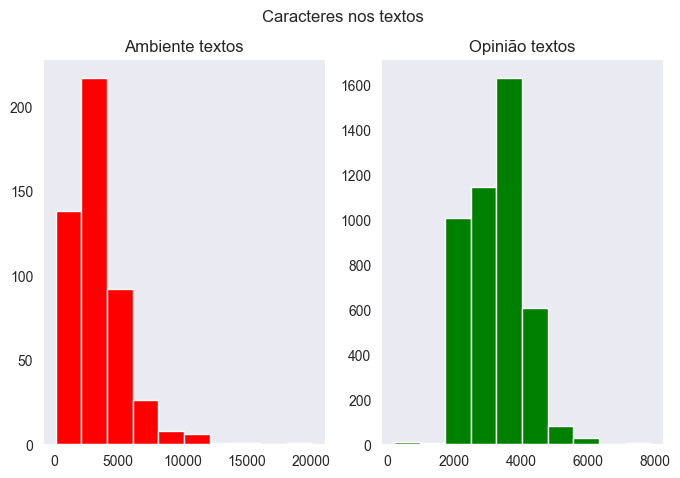

In [27]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

text_len = df[df['category'] == 'ambiente']['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Ambiente')

text_len = df[df['category'] == 'opiniao']['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Opinião')

fig.suptitle('Caracteres nos textos')
plt.show()

**Número de palavras em cada texto**

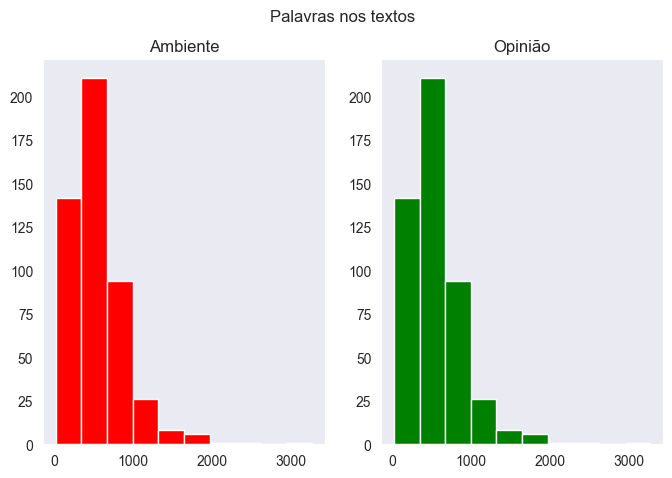

In [29]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

text_len = df[df['category'] == 'ambiente']['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Ambiente')

text_len = df[df['category'] == 'ambiente']['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len, color='green')
ax2.set_title('Opinião')

fig.suptitle('Palavras nos textos')
plt.show()

Podemos notar que o dataset está desbalanceado, para tanto, vou utilizar técnicas para compensar o desbalanceamento e analisar qual me retorna um dataset mais balanceado:

- **Undersampling**: reduzir o número de instâncias das classes majoritárias para equilibrar com as classes minoritárias;

- **Oversampling**: aumentar o número de instâncias das classes minoritárias para equilibrar com as classes majoritárias;

- **Pesos de classe**: algoritmos de aprendizado de máquina permitem atribuir pesos diferentes às classes durante o treinamento, o que pode ajudar a compensar o desequilíbrio.

### **Undersampling**

In [ ]:
from imbl